# Importing libraries and loading dataset

In [15]:
# Starting from loading the libraries required for analysis
# This was first done step by step with each model and cell but was combined finally to make the file cleaner and shorter  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

In [2]:
# Loading data
file_path = 'Monthly_New.csv'
data = pd.read_csv(file_path)

# First few rows
data.head()


,Year,Month,TotalPrimaryEnergyConsumption,TotalPrimaryEnergyProduction,TotalPrimaryEnergyExports,TotalPrimaryEnergyImports,TotalPrimaryEnergyConsumedbytheIndustrialSector,TotalPrimaryEnergyConsumedbytheResidentialSector,PrimaryEnergyStockChange
0,1973,1,7223.87,5404.72,125.78,1173.08,2027.03,1339.27,771.858
1,1973,2,6592.37,5155.12,120.88,1168.01,1841.30,1174.90,390.129
2,1973,3,6521.44,5419.56,139.95,1309.47,1926.41,983.37,-67.640
3,1973,4,5941.73,5160.81,194.19,1085.17,1914.02,715.39,-110.067
4,1973,5,6071.94,5411.25,196.78,1162.80,2076.47,535.91,-305.335


# Checking for any missing values 

In [3]:
missing_values = data.isnull().sum()
missing_values_percentage = (data.isnull().sum() / len(data)) * 100

missing_data_info = pd.DataFrame({
    'Missing Values': missing_values, 
    'Percentage': missing_values_percentage
})

missing_data_info


,Missing Values,Percentage
Year,0,0.0
Month,0,0.0
TotalPrimaryEnergyConsumption,0,0.0
TotalPrimaryEnergyProduction,0,0.0
TotalPrimaryEnergyExports,0,0.0
TotalPrimaryEnergyImports,0,0.0
TotalPrimaryEnergyConsumedbytheIndustrialSector,0,0.0
TotalPrimaryEnergyConsumedbytheResidentialSector,0,0.0
PrimaryEnergyStockChange,0,0.0


## Converting data into time series format

In [4]:
# Creating a unique identifier for each year (sequence from 1 to 74) - To use it as a feature while building models
# Combining 'Year' and 'Month' columns into a new 'Date' column which displays time-series format
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str), format='%Y-%m')

data['t'] = range(1, len(data) + 1)

print(data.head())
data.info()



   Year  Month  TotalPrimaryEnergyConsumption  TotalPrimaryEnergyProduction  \
0  1973      1                        7223.87                       5404.72   
1  1973      2                        6592.37                       5155.12   
2  1973      3                        6521.44                       5419.56   
3  1973      4                        5941.73                       5160.81   
4  1973      5                        6071.94                       5411.25   

   TotalPrimaryEnergyExports  TotalPrimaryEnergyImports  \
0                     125.78                    1173.08   
1                     120.88                    1168.01   
2                     139.95                    1309.47   
3                     194.19                    1085.17   
4                     196.78                    1162.80   

   TotalPrimaryEnergyConsumedbytheIndustrialSector  \
0                                          2027.03   
1                                          1841.30   
2       

The dataset does not have any missing values, which is excellent for analysis and model training purposes.

# Normalize data and add features to forecast Production

In [31]:
# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Defining features and target variable
features = ['TotalPrimaryEnergyConsumption', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't', 'PrimaryEnergyStockChange']
target = ['TotalPrimaryEnergyProduction']
scaled_data = scaler.fit_transform(data[features])

# Converting scaled data back to a dataframe
scaled_data_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Splitting the data into a training set (1973-2016) and a test set (2017-2022)
train_data = scaled_data_df[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
test_data = scaled_data_df[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

# Reshaping the data to fit the GRU input shape
X_train = train_data.values.reshape((train_data.shape[0], 1, train_data.shape[1]))
X_test = test_data.values.reshape((test_data.shape[0], 1, test_data.shape[1]))

# Since we're going to perform one-step-ahead prediction, the target is the same as the input shifted by one time step
y_train = train_data.values[1:]
y_test = test_data.values[1:]

# Trimming the last sample of the training and test input data coz there is no label for it
X_train = X_train[:-1, :, :]
X_test = X_test[:-1, :, :]

# Confirming the shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape




((527, 1, 5), (527, 5), (71, 1, 5), (71, 5))

In [32]:
# Defining the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model_gru.add(Dense(y_train.shape[1]))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Training the GRU model
history_gru = model_gru.fit(X_train, y_train, epochs=200, batch_size=42, validation_split=0.2, verbose=1)

# Evaluating model on test data
test_loss_gru = model_gru.evaluate(X_test, y_test)

# Making Predictions with the GRU model
y_pred_gru = model_gru.predict(X_test)




Epoch 1/200
11/11 [==============================] - 2s 37ms/step - loss: 0.1458 - val_loss: 0.2594
Epoch 2/200
11/11 [==============================] - 0s 9ms/step - loss: 0.1115 - val_loss: 0.1968
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0845 - val_loss: 0.1444
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0611 - val_loss: 0.1006
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0408 - val_loss: 0.0677
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0461
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0374
Epoch 8/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0367
Epoch 9/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0137 - val_loss: 0.0360
Epoch 10/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0355
Epoch 11

## Error and performance calculation

In [33]:
# Mean Squared Error (MSE) 
mse_gru = mean_squared_error(y_test, y_pred_gru)

# Mean Absolute Error (MAE) 
mae_gru = mean_absolute_error(y_test, y_pred_gru)

# Root Mean Squared Error (RMSE) 
rmse_gru = np.sqrt(mse_gru)

# Results 
print(f'Mean Squared Error (MSE) for GRU: {mse_gru:.2f}')
print(f'Mean Absolute Error (MAE) for GRU: {mae_gru:.2f}')
print(f'Root Mean Squared Error (RMSE) for GRU: {rmse_gru:.2f}')

Mean Squared Error (MSE) for GRU: 0.04
Mean Absolute Error (MAE) for GRU: 0.17
Root Mean Squared Error (RMSE) for GRU: 0.21


**Analysis**:

- The MSE and RMSE values indicate that the model is making accurate predictions, with relatively small errors. The MAE value represents the absolute prediction error.

- Specifically, for the Production test set, the MSE is 0.04, RMSE is 0.21, and MAE is 0.17. These low error values suggest that the GRU model performed well in predicting Total Primary Energy Production.

# Plotting Actual Vs Forecast Total Primary Energy Production

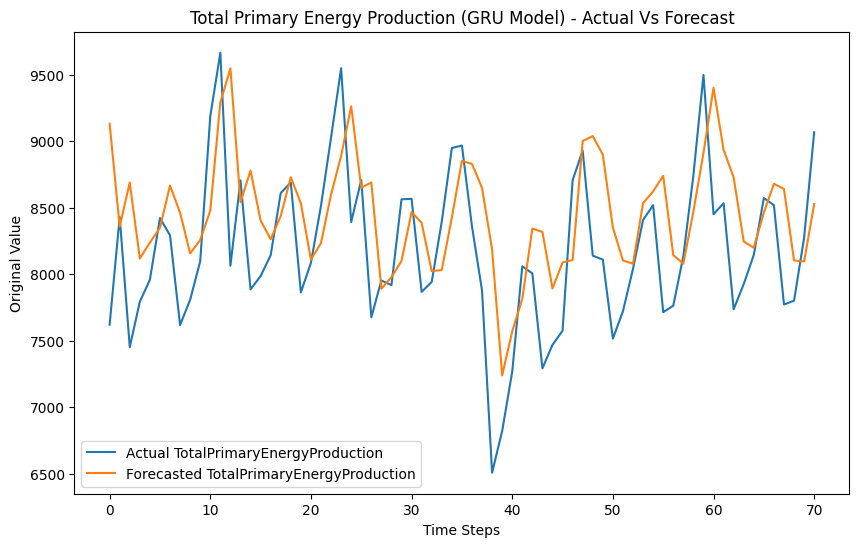

In [34]:
y_pred_actual = scaler.inverse_transform(y_pred_gru)
y_test_actual = scaler.inverse_transform(y_test)


plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 0], label='Actual TotalPrimaryEnergyProduction')
plt.plot(y_pred_actual[:, 0], label='Forecasted TotalPrimaryEnergyProduction')
plt.title('Total Primary Energy Production (GRU Model) - Actual Vs Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Original Value')
plt.legend()
plt.show()


**Analysis**:

- The visual comparison between the actual and forecasted plots is promising, indicating that the predictions have low errors and the forecasts are accurate.


# Normalize data and add features to forecast Consumption

In [35]:
scaler = MinMaxScaler()

features = ['TotalPrimaryEnergyProduction', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports','t', 'PrimaryEnergyStockChange']
target = ['TotalPrimaryEnergyConsumption']

scaled_features = scaler.fit_transform(data[features])
scaled_target = scaler.fit_transform(data[target])

scaled_data_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
scaled_target_df = pd.DataFrame(scaled_target, columns=target, index=data.index)

train_data = scaled_data_df[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
test_data = scaled_data_df[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

y_train = scaled_target_df[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
y_test = scaled_target_df[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

X_train = train_data.values.reshape((train_data.shape[0], 1, train_data.shape[1]))
X_test = test_data.values.reshape((test_data.shape[0], 1, test_data.shape[1]))


X_train = X_train[:-1, :, :]
y_train = y_train[:-1]
X_test = X_test[:-1, :, :]
y_test = y_test[:-1]


X_train.shape, y_train.shape, X_test.shape, y_test.shape


((527, 1, 5), (527, 1), (71, 1, 5), (71, 1))

In [36]:
# Defining the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model_gru.add(Dense(y_train.shape[1]))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Training the GRU model
history_gru = model_gru.fit(X_train, y_train, epochs=200, batch_size=42, validation_split=0.2, verbose=1)

# Evaluating model on test data
test_loss_gru = model_gru.evaluate(X_test, y_test)

# Making Predictions with the GRU model
y_pred_gru = model_gru.predict(X_test)




Epoch 1/200
11/11 [==============================] - 2s 26ms/step - loss: 0.2111 - val_loss: 0.3111
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 0.1479 - val_loss: 0.1982
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0947 - val_loss: 0.1041
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0536 - val_loss: 0.0399
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0298 - val_loss: 0.0129
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0224 - val_loss: 0.0101
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0221 - val_loss: 0.0115
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0104
Epoch 9/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0094
Epoch 10/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0183 - val_loss: 0.0092
Epoch 11

In [37]:
# Mean Squared Error (MSE) 
mse_gru = mean_squared_error(y_test, y_pred_gru)

# Mean Absolute Error (MAE) 
mae_gru = mean_absolute_error(y_test, y_pred_gru)

# Root Mean Squared Error (RMSE) 
rmse_gru = np.sqrt(mse_gru)

# Results 
print(f'Mean Squared Error (MSE) for GRU: {mse_gru:.2f}')
print(f'Mean Absolute Error (MAE) for GRU: {mae_gru:.2f}')
print(f'Root Mean Squared Error (RMSE) for GRU: {rmse_gru:.2f}')

Mean Squared Error (MSE) for GRU: 0.00
Mean Absolute Error (MAE) for GRU: 0.04
Root Mean Squared Error (RMSE) for GRU: 0.05


**Analysis**:

- For the Consumption test set, the MSE is 0.00, RMSE is 0.05, and MAE is 0.04. These low error values suggest that the GRU model performed exceptionally well in predicting Total Primary Energy Consumption.

- In summary, the GRU model demonstrated good performance for both Production and Consumption forecasts.

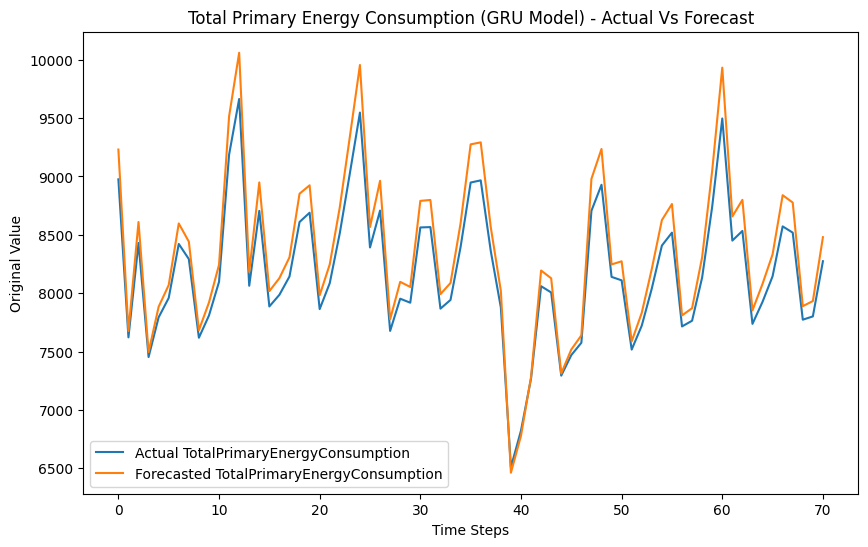

In [38]:
y_pred_actual = scaler.inverse_transform(y_pred_gru)
y_test_actual = scaler.inverse_transform(y_test)


plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 0], label='Actual TotalPrimaryEnergyConsumption')
plt.plot(y_pred_actual[:, 0], label='Forecasted TotalPrimaryEnergyConsumption')
plt.title('Total Primary Energy Consumption (GRU Model) - Actual Vs Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Original Value')
plt.legend()
plt.show()


**Analysis**:

- The visual comparison between the actual and forecasted plots indicates a high level of accuracy, validating that the predictions have low errors, and the forecasts are quite accurate.
